In [23]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import metrics

In [24]:
df = pd.read_csv(r"C:\Users\anany\Downloads\complaints.csv\complaints.csv")
df.head()

C:\Users\anany\AppData\Local\Temp\ipykernel_23592\3023111814.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\anany\Downloads\complaints.csv\complaints.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-24,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,Experian Information Solutions Inc.,NJ,07024,NaN,Other,Web,2023-08-24,In progress,Yes,NaN,7452639
1,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",FL,33972,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7512160
2,2023-07-13,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,Citibank allowed debit card transactions to ov...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,XXXXX,NaN,Consent provided,Web,2023-07-13,Closed with explanation,Yes,NaN,7244354
3,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",FL,33884,Servicemember,NaN,Web,2023-08-25,Closed with non-monetary relief,Yes,NaN,7453721
4,2023-09-13,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",TX,77521,NaN,NaN,Web,2023-09-13,Closed with explanation,Yes,NaN,7542838


In [25]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.head()

,Product,Consumer_complaint
2,Checking or savings account,Citibank allowed debit card transactions to ov...
6,"Credit reporting, credit repair services, or o...",I submitted a letter to the XXXX Credit Bureau...
37,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
38,"Credit reporting, credit repair services, or o...","On XX/XX/, 2023, XXXX XXXX admitted liability ..."
40,"Credit reporting, credit repair services, or o...",XX/XX/XXXX ] [ XXXX XXXX XXXX ] [ XXXX XXXX XX...


In [26]:
df1.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)



In [27]:
pd.DataFrame(df1.Product.unique())


,0
0,Checking or savings account
1,"Credit reporting, repair, or other"
2,Credit card or prepaid card
3,Debt collection
4,Mortgage
5,Credit reporting or other personal consumer re...
6,Vehicle loan or lease
7,Student loan
8,Debt or credit management
9,"Payday loan, title loan, or personal loan"


In [28]:
df1['category_id'] = df1['Product'].factorize()[0]
category_id_df = df1[['Product', 'category_id']].drop_duplicates()

# for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df1.head()


,Product,Consumer_complaint,category_id
2,Checking or savings account,Citibank allowed debit card transactions to ov...,0
6,"Credit reporting, repair, or other",I submitted a letter to the XXXX Credit Bureau...,1
37,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting a...,1
38,"Credit reporting, repair, or other","On XX/XX/, 2023, XXXX XXXX admitted liability ...",1
40,"Credit reporting, repair, or other",XX/XX/XXXX ] [ XXXX XXXX XXXX ] [ XXXX XXXX XX...,1


Text(0.5, 0, 'Number of ocurrences')

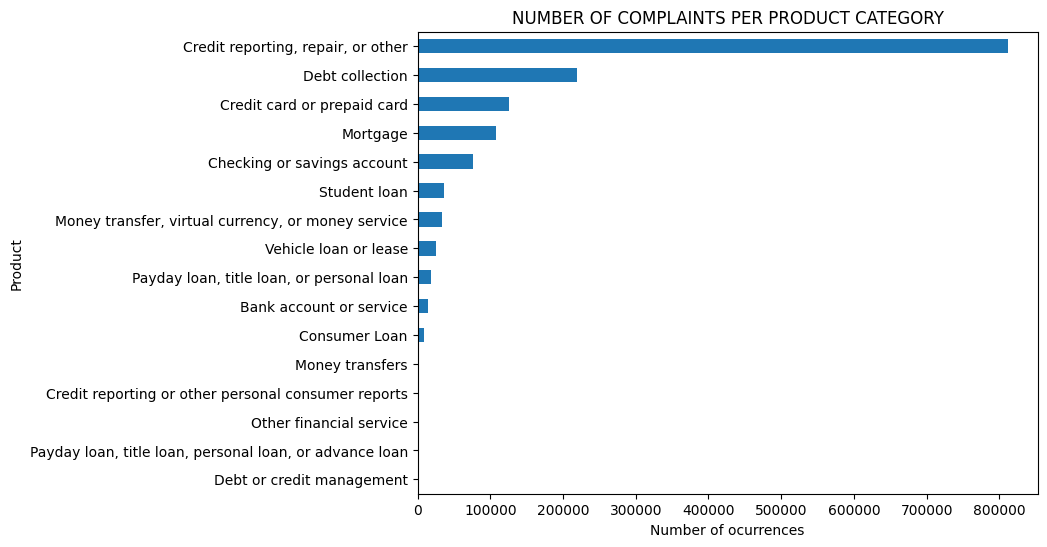

In [29]:
fig = plt.figure(figsize=(8,6))
df1.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF COMPLAINTS PER PRODUCT CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [30]:
df2 = df1.sample(10000, random_state=1).copy()
# taking a data sample to decrease processing time

In [31]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# transforming each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()
labels = df2.category_id

In [32]:
# Finding the three most correlated terms with each of the product categories
n = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("--> %s:" %(Product))
  print("  * Most Correlated Unigrams: %s" %(', '.join(unigrams[-n:])))
  print("  * Most Correlated Bigrams: %s" %(', '.join(bigrams[-n:])))

--> Bank account or service:
  * Most Correlated Unigrams: branch, citigold, overdraft
  * Most Correlated Bigrams: personal banker, xxxx overdraft, overdraft fee
--> Checking or savings account:
  * Most Correlated Unigrams: deposit, funds, checking
  * Most Correlated Bigrams: debit card, savings account, checking account
--> Consumer Loan:
  * Most Correlated Unigrams: repossessed, car, toyota
  * Most Correlated Bigrams: corporation xxxx, purchased vehicle, repossessed car
--> Credit card or prepaid card:
  * Most Correlated Unigrams: merchant, citi, card
  * Most Correlated Bigrams: card company, american express, credit card
--> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams: turned, mis, carefully
  * Most Correlated Bigrams: xxxx turned, turned credit, later 30
--> Credit reporting, repair, or other:
  * Most Correlated Unigrams: 1681, section, reporting
  * Most Correlated Bigrams: reporting agency, 15 1681, 1681 section
--> Debt collection:


In [33]:
X = df2['Consumer_complaint']
y = df2['Product']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

********************************
CLASSIFYING USING SVM
********************************

In [34]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df2.index, test_size=0.25, random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

c:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [35]:
rep = metrics.classification_report(y_test, y_pred)
print(rep)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       126
           1       0.88      0.93      0.91      1391
           2       0.70      0.77      0.73       185
           3       0.72      0.74      0.73       347
           4       0.85      0.91      0.88       189
           6       0.73      0.31      0.44        51
           7       0.91      0.69      0.78        70
           9       0.25      0.08      0.12        26
          10       0.70      0.56      0.62        62
          12       0.00      0.00      0.00        23
          13       0.67      0.07      0.12        29
          14       0.00      0.00      0.00         1

    accuracy                           0.82      2500
   macro avg       0.59      0.48      0.50      2500
weighted avg       0.81      0.82      0.81      2500



c:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

************************************************************************************************************
RUNNING MODEL ON UNSEEN DATA
************************************************************************************************************

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

c:\Users\anany\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [38]:
complaint = """I have received over 27 emails from X who is a representative from Midland Funding LLC. 
On XX/XX/XXXX I received approximately 6 emails. On XX/XX/XXXX I received approximately 9 emails.  
All emails came from the same individual, X. It is becoming a nonstop issue of harassment."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Debt collection']


In [39]:
complaint2 = "I wanted to check for the interest rate for taking out loan for my university education but was never given a straight answer."
print(model.predict(fitted_vectorizer.transform([complaint2])))

['Student loan']


In [40]:
complaint3 = "My debit card got declined today even though there are funds in my account."
print(model.predict(fitted_vectorizer.transform([complaint3])))

['Checking or savings account']


In [41]:
complaint4 = "I am having trouble registering for a credit card on the online portal."
print(model.predict(fitted_vectorizer.transform([complaint4])))

['Credit card or prepaid card']
